In [1]:
!pip3 install tensorflow_hub tensorflow scikit-learn pillow numpy scikit-image

    100% |████████████████████████████████| 92kB 5.3MB/s ta 0:00:011
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow_hub as tf_hub
import tensorflow as tf
#from image_augment import ImageAugment
import s3fs

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

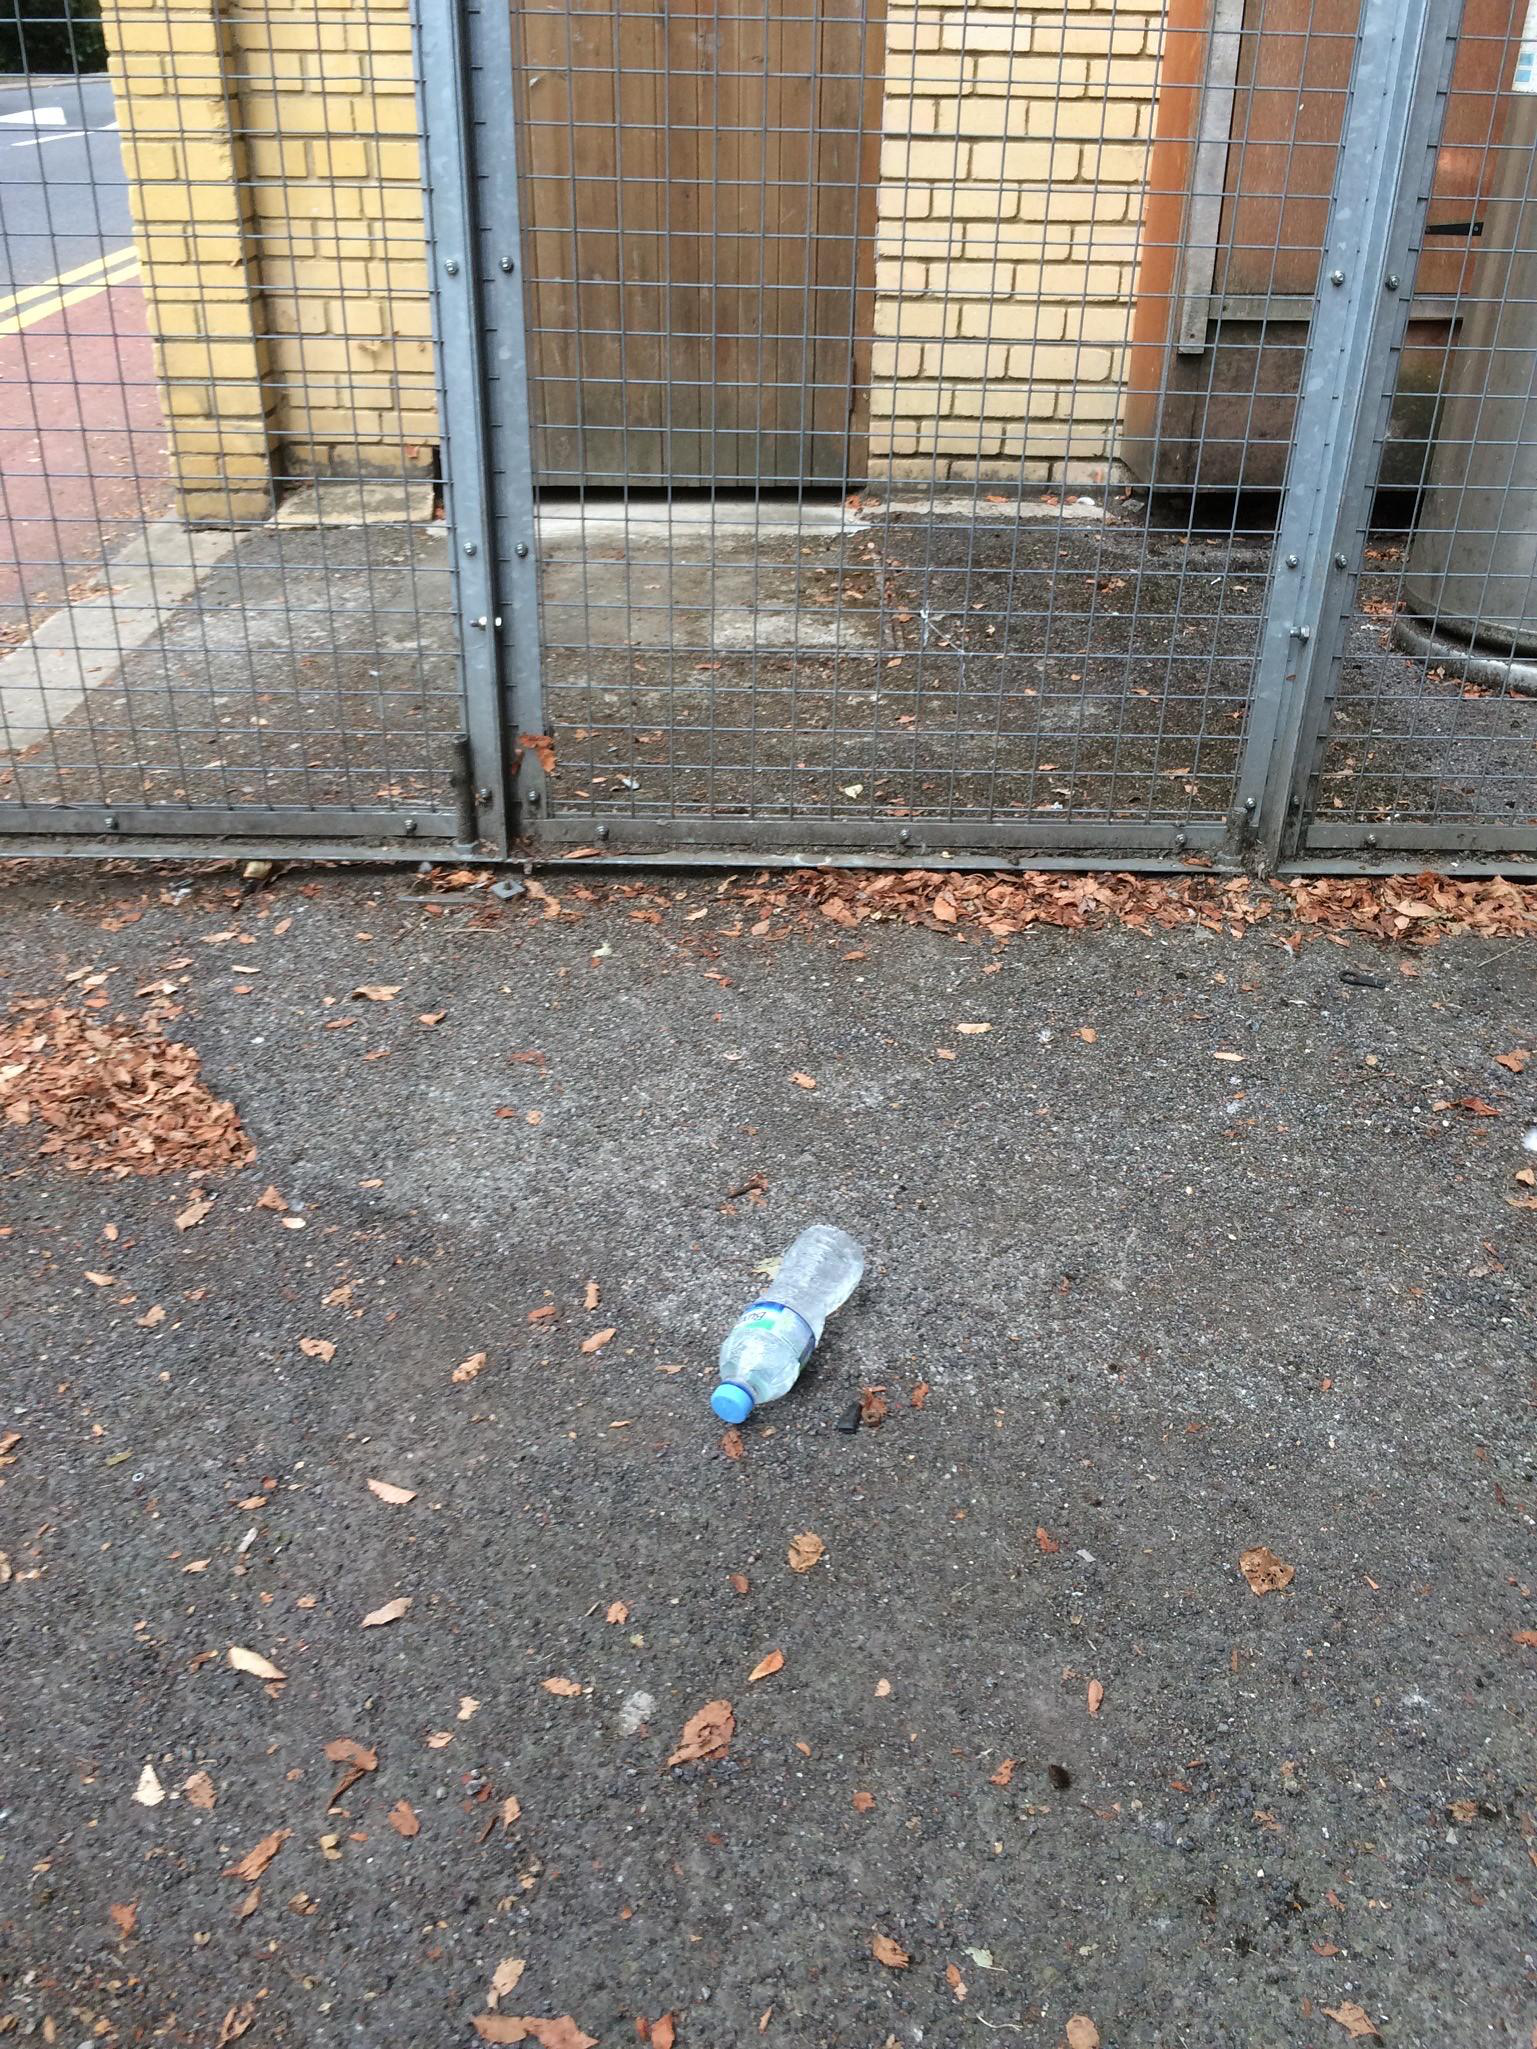

In [3]:
fs = s3fs.S3FileSystem()

fs.ls('s3://ucb-mids-wall-e/TACO/')
fs.ls('s3://ucb-mids-wall-e/TrashNet')

with fs.open(f's3://ucb-mids-wall-e/TACO/batch_1/000000.jpg') as f:
    display(Image.open(f))

In [4]:
# Augment Images
#ImageAugment.execute("data", ["fliph","noise_0.05","trans_20_20","blur_2.0"])

In [5]:
# Load and split image data
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def preprocess_image(s3_img_path):
    with fs.open(s3_img_path) as f:
        img = Image.open(f)
        w, h = img.size
        img = crop_center(img, min(w,h), min(w,h))
        img = img.resize((300, 300))    
        img = np.asarray(img)/256.0    
        return img

Taco folders: ['ucb-mids-wall-e/TACO/batch_1', 'ucb-mids-wall-e/TACO/batch_10', 'ucb-mids-wall-e/TACO/batch_11', 'ucb-mids-wall-e/TACO/batch_12', 'ucb-mids-wall-e/TACO/batch_13', 'ucb-mids-wall-e/TACO/batch_14', 'ucb-mids-wall-e/TACO/batch_15', 'ucb-mids-wall-e/TACO/batch_2', 'ucb-mids-wall-e/TACO/batch_3', 'ucb-mids-wall-e/TACO/batch_4', 'ucb-mids-wall-e/TACO/batch_5', 'ucb-mids-wall-e/TACO/batch_6', 'ucb-mids-wall-e/TACO/batch_7', 'ucb-mids-wall-e/TACO/batch_8', 'ucb-mids-wall-e/TACO/batch_9']
Loading TACO folder ucb-mids-wall-e/TACO/batch_1...
Loading TACO folder ucb-mids-wall-e/TACO/batch_10...
Loading TACO folder ucb-mids-wall-e/TACO/batch_11...
Loading TACO folder ucb-mids-wall-e/TACO/batch_12...
Loading TACO folder ucb-mids-wall-e/TACO/batch_13...
Loading TACO folder ucb-mids-wall-e/TACO/batch_14...
Loading TACO folder ucb-mids-wall-e/TACO/batch_15...
Loading TACO folder ucb-mids-wall-e/TACO/batch_2...
Loading TACO folder ucb-mids-wall-e/TACO/batch_3...
Loading TACO folder ucb-m

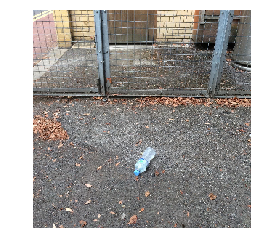

In [6]:
taco_data_path = 's3://ucb-mids-wall-e/TACO' #'data/TACO/data'
taco_image_folders = fs.ls(taco_data_path)
print(f"Taco folders: {taco_image_folders}")

images = []
flag = True
for folder in taco_image_folders:
    if "batch" in folder:
        print(f"Loading TACO folder {folder}...")
        for img in fs.ls(folder):
            # Load image
            I = preprocess_image(img)

            # Show image
            if flag:
                fig,ax = plt.subplots(1)
                plt.axis('off')
                plt.imshow(I)
                flag = False

            if I.shape == (300, 300, 3):
                images.append(I)
            else:
                print(f"Not adding {img} due to improper shape... Count={count}")
taco_img_count = len(images)
print(f"Taco Image Count: {taco_img_count}")

TrashNet folders: ['ucb-mids-wall-e/TrashNet/cardboard', 'ucb-mids-wall-e/TrashNet/glass', 'ucb-mids-wall-e/TrashNet/metal', 'ucb-mids-wall-e/TrashNet/paper', 'ucb-mids-wall-e/TrashNet/plastic', 'ucb-mids-wall-e/TrashNet/trash']
Loading TrashNet folder ucb-mids-wall-e/TrashNet/cardboard...
Loading TrashNet folder ucb-mids-wall-e/TrashNet/glass...
Loading TrashNet folder ucb-mids-wall-e/TrashNet/metal...
Loading TrashNet folder ucb-mids-wall-e/TrashNet/paper...
Loading TrashNet folder ucb-mids-wall-e/TrashNet/plastic...
Loading TrashNet folder ucb-mids-wall-e/TrashNet/trash...
TrashNet Image Count: 2527


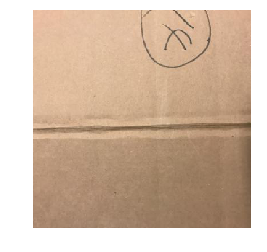

In [7]:
trashnet_data_path = 's3://ucb-mids-wall-e/TrashNet' #'data/TrashNet'
trashnet_image_folders = fs.ls(trashnet_data_path)
print(f"TrashNet folders: {trashnet_image_folders}")

flag = True
for folder in trashnet_image_folders:
    if "_" not in folder:
        print(f"Loading TrashNet folder {folder}...")
        for img in fs.ls(folder):
            # Load image
            I = preprocess_image(img)

            # Show image
            if flag:
                fig,ax = plt.subplots(1)
                plt.axis('off')
                plt.imshow(I)
                flag = False

            if I.shape == (300, 300, 3):
                images.append(I)
            else:
                print(f"Not adding {img} due to improper shape...")

trashnet_img_count = len(images) - taco_img_count
print(f"TrashNet Image Count: {trashnet_img_count}")

pos_label_count = taco_img_count + trashnet_img_count
labels = [1]*pos_label_count

Random Image Count: 4027
Not adding ucb-mids-wall-e/val2017/000000007888.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000024021.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000061418.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000130465.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000141671.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000205289.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000209222.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000274219.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000353180.jpg due to improper shape...
Not adding ucb-mids-wall-e/val2017/000000431848.jpg due to improper shape...


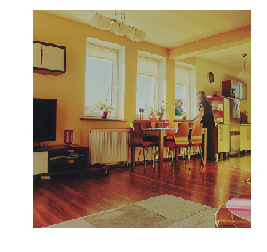

In [8]:
random_data_path = 's3://ucb-mids-wall-e/val2017' #'val2017'
random_image_files = fs.ls(random_data_path)[:pos_label_count]

random_img_count = len(random_image_files)
print(f"Random Image Count: {random_img_count}")
            
flag = True    
for i, img in enumerate(random_image_files):
    # Load image
    I = preprocess_image(img)

    # Show image
    if flag:
        flag = False
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(I)

    if I.shape == (300, 300, 3):
        images.append(I)
    else:
        print(f"Not adding {img} due to improper shape...")

In [9]:
# Split data
#images = taco_images[:1800] + random_images[:1800]
labels = [1]*pos_label_count + [0]*(len(images)-pos_label_count)
print(f"Image total: {len(images)}")

train_x, val_x, train_y, val_y = train_test_split(np.array(images), np.array(labels), test_size=0.20, random_state=7)

Image total: 8044


In [10]:
# Create basic mobilenet binary classification model - TF 2.0 model layer
models = ['https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4'
          #'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4',
          #'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4',
          #'https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/4',
          ]

epochs = 30
batch_size = 64
best_model = None
best_history = None
best_acc = 0.0
for model_arch in models:
    print(f"Building {model_arch}... epochs={epochs}, batch_size={batch_size}")
    model = tf.keras.Sequential([
        #arguments=dict(batch_norm_momentum=0.997)
        tf_hub.KerasLayer(model_arch, trainable=False),  
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.build([None, 300, 300, 3])  
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',  
                  metrics=['accuracy'])
    print("Fitting...")
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) 

Building https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4... epochs=30, batch_size=64
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Fitting...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6435 samples, validate on 1609 samples
Epoch 1/30
6435/6435 [==============================] - 128s 20ms/sample - loss: 0.1582 - acc: 0.9442 - val_loss: 0.0704 - val_acc: 0.9795
Epoch 2/30
6435/6435 [==============================] - 123s 19ms/sample - loss: 0.0565 - acc: 0.9840 - val_loss: 0.0506 - val_acc: 0.9845
Epoch 3/30
6435/6435 [==============================] - 123s 19ms/sample - loss: 0.0414 - acc: 0.9877 - val_loss: 0.0447 - val_acc: 0.9851
Epoch 4/30
6435/6435 [==============================] - 123s 19ms/sample - loss: 0.0325 - acc: 0.9915 - val_loss: 0.0453 - val_acc: 0.9863
Epoch 5/30
6435/6435 [==============================] - 124s 19ms/sample - loss: 0.0273 - acc: 0.9927 - val_loss: 0.0387 - val_acc: 0.9857
Epoch 6/30
6435/6435 [==============================] - 123s 19ms/sample - loss: 0.0235 - acc: 0.9938 - val_loss: 0.0360 - val_acc: 0.9882
Epoch 7/30
6435/6435 [==============================] - 124s 19ms/sample - loss: 0.0195 - acc: 0.9961 - val_loss: 0.03

KeyError: 'val_accuracy'

In [13]:
print(history.history)
val_acc = history.history['val_acc'][1]
print(f"Val Acc: {val_acc}")

if val_acc > best_acc:
    best_history = history
    best_model = model
    best_acc = val_acc

{'loss': [0.15815233907430043, 0.05649130035715689, 0.041424714574169165, 0.03252331022037122, 0.027313641595372695, 0.02349959957089909, 0.019467276647663803, 0.01690021882118786, 0.014738615869422152, 0.013178214089685896, 0.011686386669195014, 0.01030781058957851, 0.009633954383343133, 0.008472738035816321, 0.007464439326227174, 0.006773662324285637, 0.006300356958087508, 0.0056732340855487765, 0.005264382331654511, 0.004762037240096137, 0.004380167766004546, 0.00400504504503044, 0.003661371496798747, 0.0034188717955258648, 0.0031936856684482654, 0.0029624719714540365, 0.002753060052052673, 0.0025635047367174777, 0.002430781001220953, 0.002229885575082949], 'acc': [0.94421136, 0.98399377, 0.9877234, 0.991453, 0.99269617, 0.993784, 0.99611497, 0.9965812, 0.9967366, 0.9979798, 0.9982906, 0.9989122, 0.9989122, 0.9993784, 0.9995338, 0.9993784, 0.9995338, 0.9995338, 0.9998446, 0.9998446, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.07044767171626064, 0.05060235264487

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23561152  
_________________________________________________________________
dense (Dense)                multiple                  2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


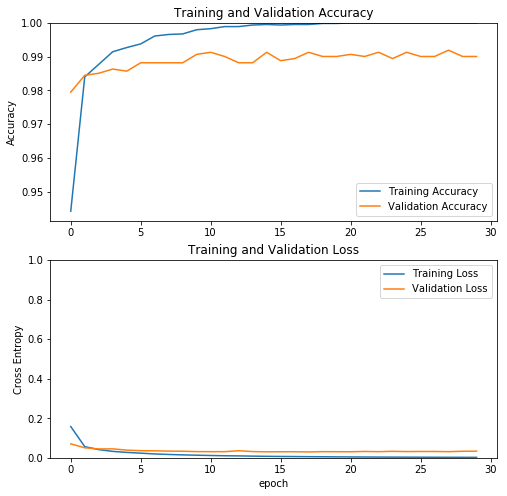

In [14]:
# Plot accuracy vs loss graphs
# Show model architecture
best_model.summary()

acc = best_history.history['acc']
val_acc = best_history.history['val_acc']

loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

array([[0.9999988]], dtype=float32)

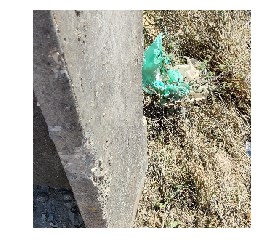

In [18]:
# example prediction
test_img = preprocess_image('s3://ucb-mids-wall-e/TACO/batch_10/000006.jpg')
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(test_img)

best_model.predict(np.array([test_img]),
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False)